In [76]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display
from PIL import Image

# Bar Chart

In [77]:
#Read the CSV file
df = pd.read_csv('../data/bar_assignment.csv')

#Transform 1 -> "Yes" and 0 -> "No"
df['COUNT'] = df['COUNT'].replace({1: 'Yes', 0: 'No'})

#Group by LABEL and COUNT, then count occurrences
grouped_df = df.groupby(['LABEL', 'COUNT']).size().reset_index(name='TOTAL')

#Sort the DataFrame alphabetically by LABEL
grouped_df = grouped_df.sort_values(by='LABEL')

#Create the horizontal stacked bar chart
fig = px.bar(
    grouped_df, 
    x='TOTAL', 
    y='LABEL', 
    color='COUNT', 
    orientation='h', 
    barmode='stack',
    labels={'TOTAL': 'Count', 'LABEL': 'Label', 'COUNT': 'Response'},
    title='Horizontal Stacked Bar Chart: Yes/No Responses by Label',
    color_discrete_map={'Yes': 'blue', 'No': 'red'}  # Set colors for Yes and No
)

# Move the legend to the top-left and arrange it horizontally
fig.update_layout(
    legend=dict(
        title='Response',
        orientation='h',  # Horizontal legend
        yanchor='bottom',  # Anchor legend at the bottom
        y=1.02,  # Position legend above the chart
        xanchor='left',  # Anchor legend to the left
        x=0  # Position legend at the left
    )
)

# Add bar labels (values) at the tail end of each bar
fig.update_traces(
    textposition='inside',  # Place text outside the bars
    texttemplate='%{x}',  # Display the value of each bar segment
)

# Force alphabetical sorting on the y-axis
fig.update_yaxes(categoryorder='array', categoryarray=sorted(grouped_df['LABEL'].unique()))

# Show the plot
fig.show()

# Sankey Diagram

In [78]:
df = pd.read_csv('../data/sankey_assignment.csv')

# Define node layers
first_layer = ['PS', 'OMP', 'CNP', 'NRP', 'NMCCC', 'PEC', 'NCDM', 'RGS']
labels = df['LABEL'].tolist()
second_layer = ['Reg', 'Aca', 'Oth']

# Define colors to match the image
node_colors = {
    'OMP': '#54AFA9',
    'PS': '#F2A481',
    'CNP': '#F09135',
    'RGS': '#AD5ECD',
    'NRP': '#F285A6',
    'NCDM': '#F9D749',
    'NMCCC': '#A1D490',
    'PEC': '#96CDF6'
}

label_colors = {
    'S': '#87CEFA',
    'I': '#00BFFF',
    'D': '#5E9EA0',
    'F': '#4781B4',
    'N': '#6394ED'
}

# Define second-layer colors based on the image
second_layer_colors = {
  'Aca': '#90EE90',
  'Reg': '#3CB371',
  'Oth': '#32CD32'
}

# Create a list of all unique nodes
nodes = first_layer + labels + second_layer
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Assign colors to all nodes
node_color_list = [node_colors.get(node, label_colors.get(node, second_layer_colors.get(node, 'black'))) for node in nodes]

# Generate links: First Layer -> Labels -> Second Layer
sources, targets, values, colors = [], [], [], []

for _, row in df.iterrows():
    label = row['LABEL']
    for fl in first_layer:
        if row[fl] > 0:
            sources.append(node_indices[fl])
            targets.append(node_indices[label])
            values.append(row[fl])
            colors.append(node_colors[fl])  # Source color
    for sl in second_layer:
        if row[sl] > 0:
            sources.append(node_indices[label])
            targets.append(node_indices[sl])
            values.append(row[sl])
            colors.append(label_colors[label])  # Label color instead of second-layer color

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=nodes,
        color=node_color_list  # Apply custom node colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors  # Apply label colors to links
    )
))

fig.update_layout(
    title_text='Flow Analysis',
    font=dict(family='Arial', size=12)
)

fig.show()


# Network Graph

In [79]:
df = pd.read_csv('../data/networks_assignment.csv')
df.head()


,LABELS,N,D,F,I,S,AUT,BEL,BIH,BGR,...,SVK,SVN,ESP,CHE,TUR,UKR,GBR,AUS,HKG,ASU
0,D,3,0,3,1,3,0,0,0,0,...,0,0,1,0,0,0,2,0,0,1
1,F,1,2,0,1,1,0,1,0,0,...,1,1,2,1,0,0,2,0,0,0
2,I,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,N,0,2,2,1,2,0,0,0,0,...,0,0,1,0,0,0,2,1,0,1
4,S,5,4,3,3,0,2,2,2,2,...,0,0,2,2,2,2,3,1,1,1


### Creating the Graph

In [80]:
import networkx as nx

# Define node lists
Blue_nodes = ['D', 'F', 'I', 'N', 'S']
Green_nodes = ['BIH', 'GEO', 'ISR', 'MNE', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'AUS', 'HKG', 'ASU']
Yellow_nodes = ['AUT', 'BEL', 'BGR', 'HRV', 'CZE', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LUX', 'NLD', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP']
all_nodes = Blue_nodes + Green_nodes + Yellow_nodes

# Create the graph from the adjacency matrix
adj_matrix_full = df.set_index('LABELS').reindex(all_nodes, fill_value=0)
G_full = nx.from_pandas_adjacency(adj_matrix_full)

# Filter edges: only keep an edge if at least one of the nodes is blue.
selected_edges = [
    (u, v) for u, v in G_full.edges
    if (u in Blue_nodes or v in Blue_nodes)
]

# Create a new graph and add the nodes and the selected edges.
G = nx.Graph()
G.add_nodes_from(all_nodes)
G.add_edges_from(selected_edges)

# Output summary info
print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())



Number of nodes in G: 37
Number of edges in G: 67


### Making a 'pentagon' Sub-graph

In [81]:
import numpy as np

pos = {}

# Define positions for the blue nodes (DFINS) in a pentagon.
r_blue = 1.0  # radius for blue nodes
# Create angles starting at π/2 and decreasing by 2π/5 each time.
theta_blue = np.linspace(np.pi/2, np.pi/2 - 2*np.pi, len(Blue_nodes), endpoint=False)
for node, theta in zip(Blue_nodes, theta_blue):
    pos[node] = (r_blue * np.cos(theta), r_blue * np.sin(theta))

# Define positions for the outer nodes on a larger circle.
outer_nodes = [n for n in all_nodes if n not in Blue_nodes]
r_outer = 3.0  # radius for outer nodes
theta_outer = np.linspace(0, 2*np.pi, len(outer_nodes), endpoint=False)
for node, theta in zip(outer_nodes, theta_outer):
    pos[node] = (r_outer * np.cos(theta), r_outer * np.sin(theta))


### Visualizing Network Graph

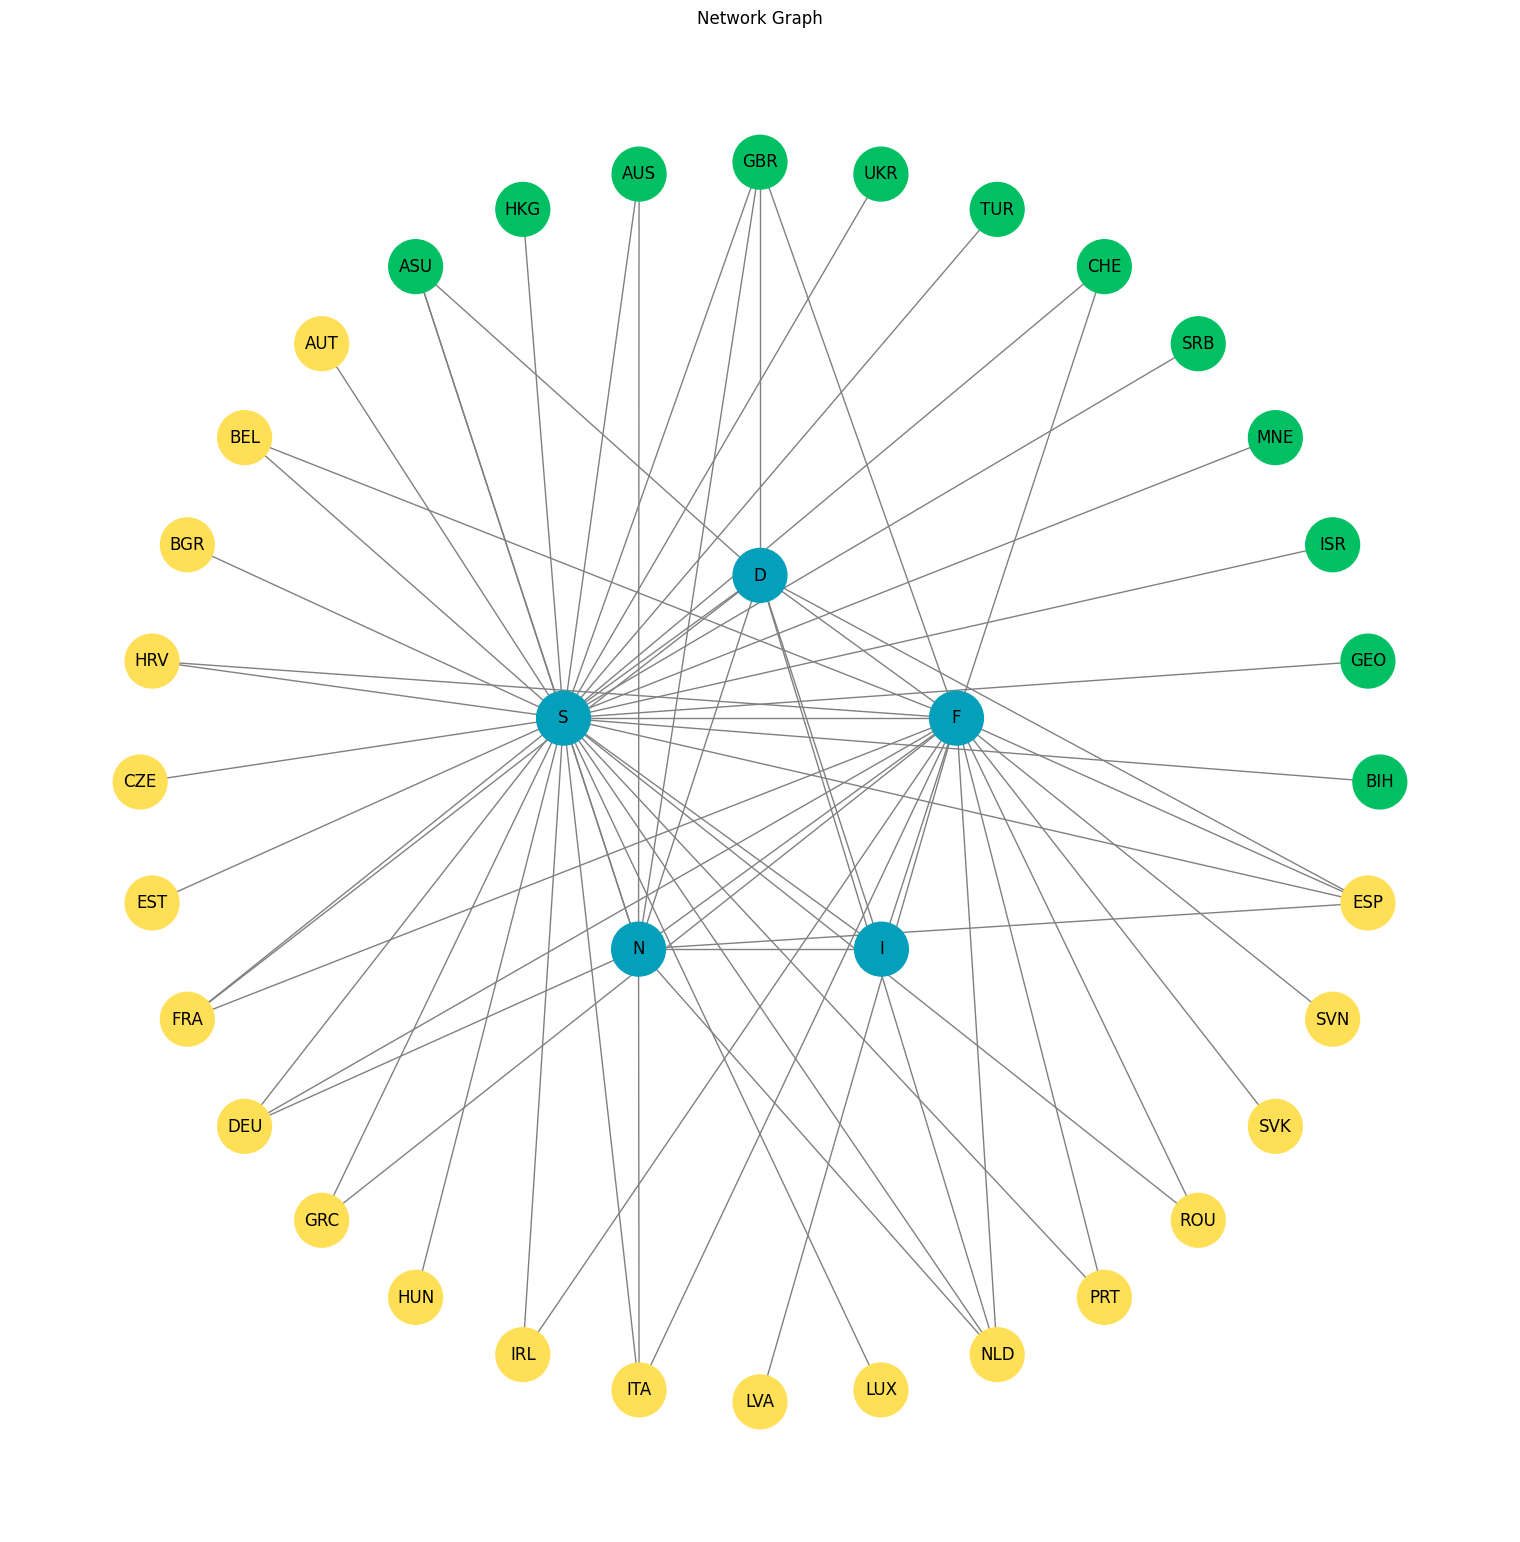

In [82]:
import matplotlib.pyplot as plt

# Colors
node_colors = []
for node in G.nodes():
    if node in Blue_nodes:
        node_colors.append('#039fbb')
    elif node in Green_nodes:
        node_colors.append('#01c063')
    elif node in Yellow_nodes:
        node_colors.append('#ffdf56')

plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, edge_color='gray')
plt.title("Network Graph")
plt.show()

### Collated Graph

A collection of horizontal bar, sankey, and network graph plots

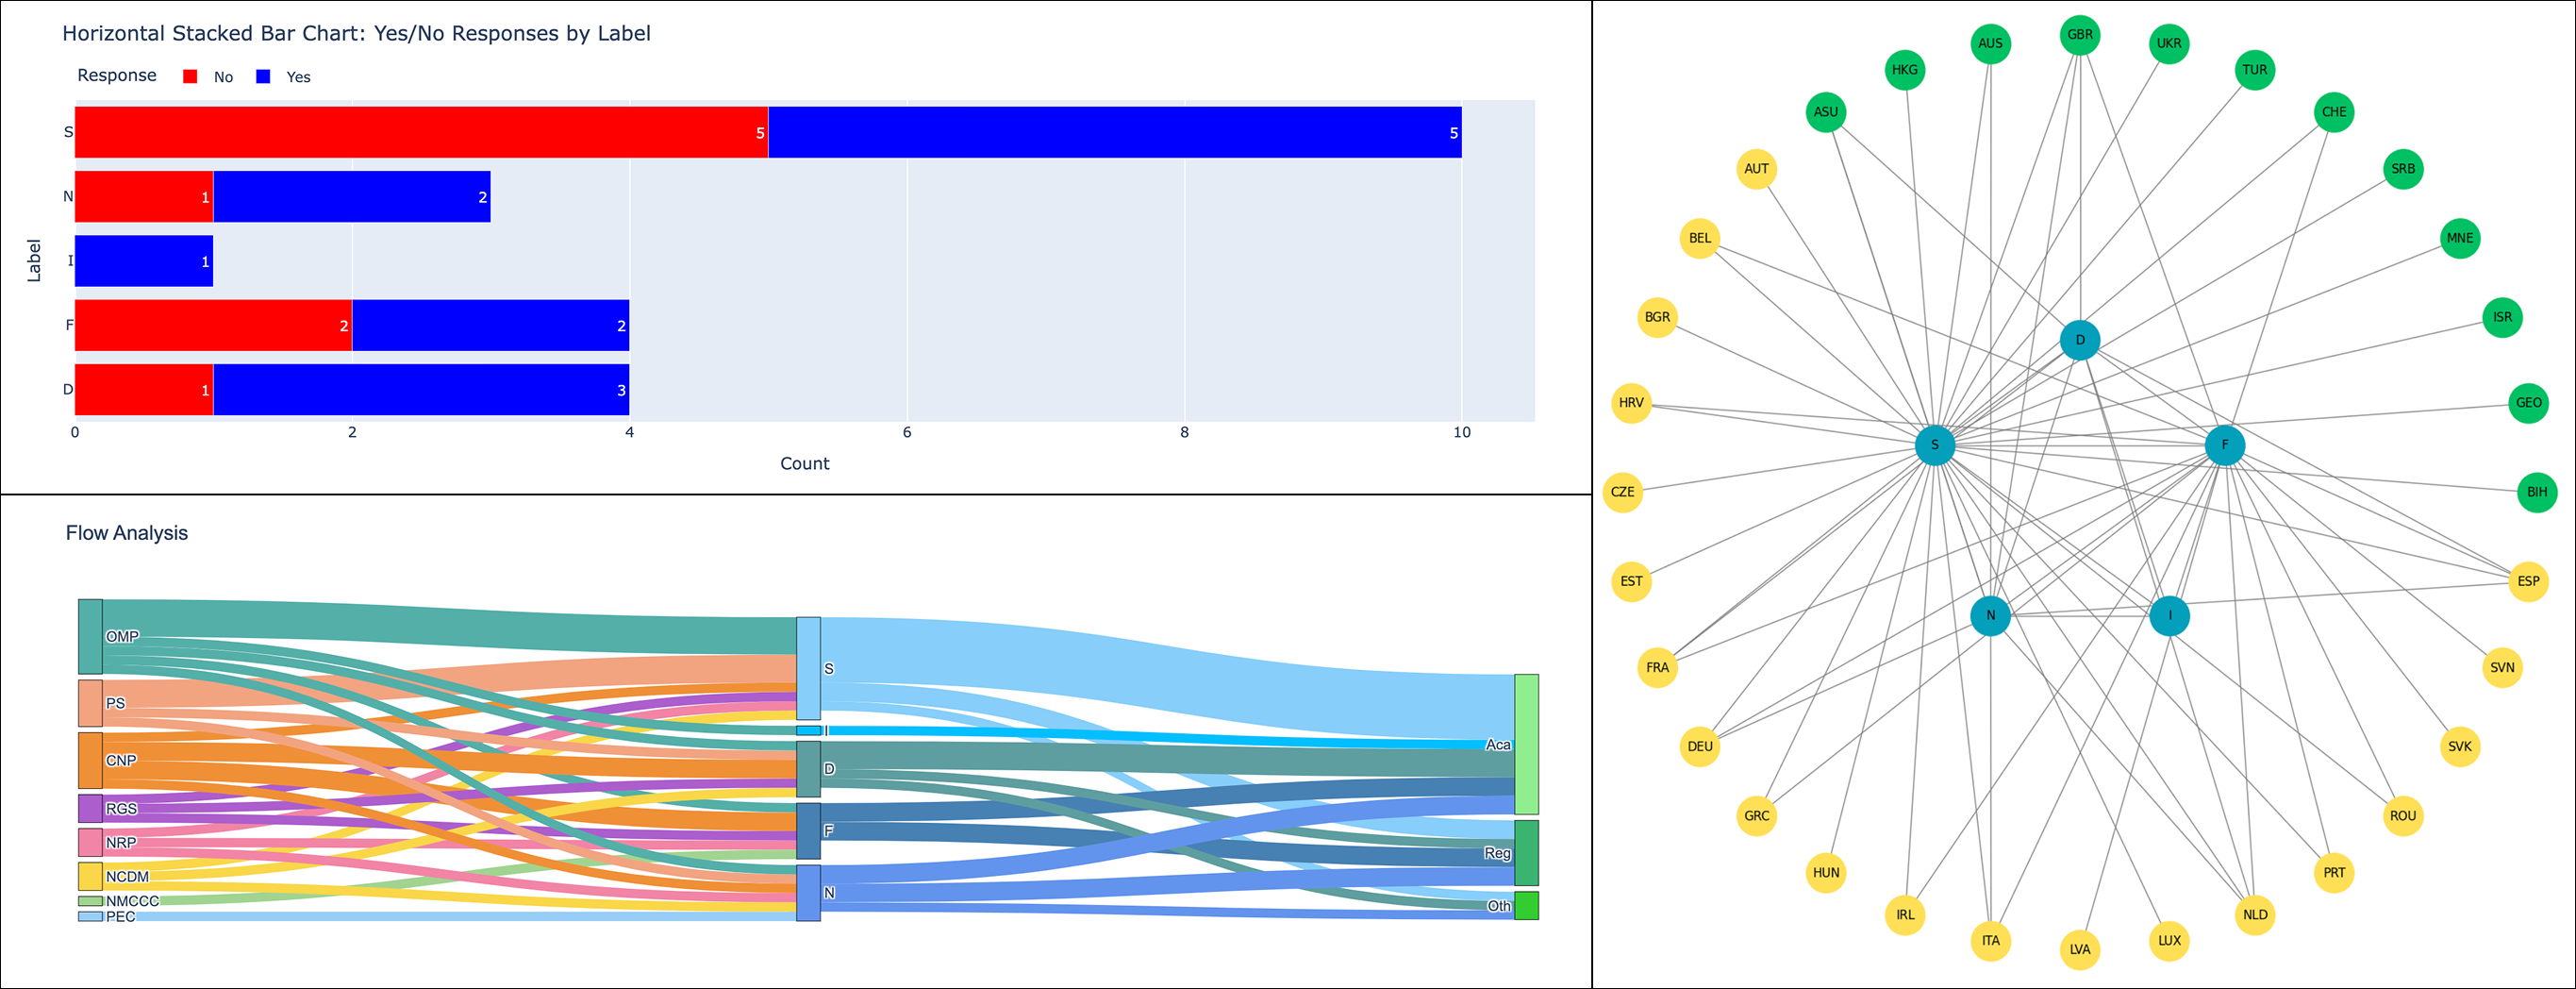

In [83]:
collated = Image.open('collated.png')
display(collated)